<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Bagging Codealong

_Authors: Joseph Nelson (DC)_

---

### 1. Import the car evaluation data.

In [1]:
import pandas as pd

df = pd.read_csv('../datasets/car.csv')

In [2]:
df.head()

,buying,maint,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


### 2. Encode the features using `LabelEncoder`.

Since most of the features are categorical text we will need to encode them as numbers using the ***LabelEncoder***.

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
features = [c for c in df.columns if c != 'acceptability']
for c in df.columns:
    df[c] = le.fit_transform(df[c])

X = df[features]
y = df['acceptability']

Notice that we overwrote the original features for simplicity, since we are not interested in doing a study on feature importance.

**Check: Is it correct to use the label encoder blindly like this?**

No, we should first do a quick EDA on the data to check null values, types, etc.

### 3. Cross-validate a KNN classifier and a `BaggingClassifier` with a KNN base estimator.


In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier


knn = KNeighborsClassifier()
bagging = BaggingClassifier(base_estimator = knn, max_samples=0.5, max_features=0.5)

print "KNN Score:\t", cross_val_score(knn, X, y, cv=5, n_jobs=-1).mean()
print "Bagging Score:\t", cross_val_score(bagging, X, y, cv=5, n_jobs=-1).mean()

KNN Score:	0.6430703051485416
Bagging Score:	0.706509611506923


**Check: Does bagging interfere with cross-validation? Are we leaking data and thus faking the cross val score?**



The BaggingClassifier works fine with cross-validation.

### Bonus - optimize n_estimators

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline 
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

In [16]:
results = []
for n_estimators in [3,5,10,20,50,100,200,500,1000]:
    bagging = BaggingClassifier(base_estimator = knn, max_samples=0.5, max_features=0.5, n_estimators=n_estimators) 
    average_result = cross_val_score(bagging, X, y, cv=5, n_jobs=-1).mean()
    print(n_estimators, average_result)
    results.append(average_result)

(3, 0.6347862615943003)
(5, 0.6329580588788815)
(10, 0.6766164807097728)
(20, 0.7402070170721872)
(50, 0.7378343863422503)
(100, 0.7337679795671461)
(200, 0.7343426535824709)
(500, 0.7314558408388223)
(1000, 0.7302997714746605)


Text(0.5,1,u'n_estimators against accuracy')

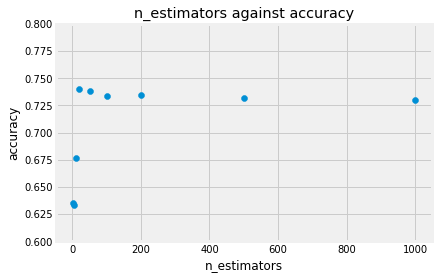

In [21]:
plt.scatter([3,5,10,20,50,100,200,500,1000],
            results)
plt.ylim(0.6,0.8)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.title('n_estimators against accuracy')

### 4. In pairs, research and describe the `max_samples` and `max_features` hyperparameters.

The BaggingClassifier meta-estimator has several parameters.

**Check: In pairs, look at the documentation for a detailed description of each and find out what ```max_samples``` and ```max_features``` do.**

max_samples = max number of rows in each bootstrapped sample  
max_features = max number of features in each bootstrapped sample  

### 6. Is it possible to create a model where the output is two independent features/predictions?

In [5]:
bagging.fit(X,y)

BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=0.5, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [6]:
# this outputs one prediction per row
bagging.predict(X[:5]) 

array([2, 2, 2, 2, 2])

In [7]:
# this outputs many predictions (one for every model) for every row
bagging.predict_proba(X[:5]) 

array([[0.  , 0.  , 1.  , 0.  ],
       [0.08, 0.  , 0.92, 0.  ],
       [0.08, 0.  , 0.92, 0.  ],
       [0.06, 0.  , 0.94, 0.  ],
       [0.14, 0.  , 0.86, 0.  ]])

In [8]:
# This is not currently supported by the `BaggingClassifier` object, 
# but this multi-label fitting procedure is supported by other sklearn models.